# **Stock Prices Predictions with DeepAR**

This Notebook will contain the modeling phases needed to predict stock prices using a deep learning model.
The stocks analyzed will be the following:
* IBM
* AAPL (Apple Inc.)
* AMZN (Amazon Inc.)
* GOOGL (Alphabet Inc.)


In [226]:
import sagemaker

# Data preparation

Data must be prepared in order to be processed by DeepAR model:
* Train/test set split
* Save Data locally
* Upload to S3

In [227]:
import os

In [228]:
data_dir = 'stock_deepar'

In [229]:
# The folder we will be used to store csv data
data_dir_csv = os.path.join(data_dir, 'csv')

In [230]:
# The folder we will be used to store json data
data_dir_json = os.path.join(data_dir, 'json')

In [231]:
# The folder we will be used to store training data in json format
data_dir_json_train = os.path.join(data_dir_json, 'train')

In [232]:
# The folder we will be used to store test data in json format
data_dir_json_test = os.path.join(data_dir_json, 'test')

In [233]:
# The folder we will be used to store validation data in json format
data_dir_json_valid = os.path.join(data_dir_json, 'validation')

In [234]:
# initializing train/test dataframe lists to iterate on them
dfs_train = [df_ibm_train, df_aapl_train, df_amzn_train, df_googl_train]
dfs_test = [df_ibm_test, df_aapl_test, df_amzn_test, df_googl_test]
dfs_valid = [df_ibm_valid, df_aapl_valid, df_amzn_valid, df_googl_valid]

## Save Data Locally

In [235]:
if not os.path.exists(data_dir_csv): # Make sure that the folder exists
    os.makedirs(data_dir_csv)

In [236]:
# IBM
df_ibm_train.to_csv(os.path.join(data_dir_csv, 'ibm_train.csv'), header=True, index=True)
df_ibm_test.to_csv(os.path.join(data_dir_csv, 'ibm_test.csv'), header=True, index=True)
df_ibm_valid.to_csv(os.path.join(data_dir_csv, 'ibm_valid.csv'), header=True, index=True)

In [237]:
# Apple Inc.
df_aapl_train.to_csv(os.path.join(data_dir_csv, 'aapl_train.csv'), header=True, index=True)
df_aapl_test.to_csv(os.path.join(data_dir_csv, 'aapl_test.csv'), header=True, index=True)
df_aapl_valid.to_csv(os.path.join(data_dir_csv, 'aapl_valid.csv'), header=True, index=True)

In [238]:
# Amazon.com
df_amzn_train.to_csv(os.path.join(data_dir_csv, 'amzn_train.csv'), header=True, index=True)
df_amzn_test.to_csv(os.path.join(data_dir_csv, 'amzn_test.csv'), header=True, index=True)
df_amzn_valid.to_csv(os.path.join(data_dir_csv, 'amzn_valid.csv'), header=True, index=True)

In [239]:
# Alphabet Inc.
df_googl_train.to_csv(os.path.join(data_dir_csv, 'googl_train.csv'), header=True, index=True)
df_googl_test.to_csv(os.path.join(data_dir_csv, 'googl_test.csv'), header=True, index=True)
df_googl_valid.to_csv(os.path.join(data_dir_csv, 'googl_valid.csv'), header=True, index=True)

### JSON serialization

In order to feed DeepAR model, JSON files must be prepared from data.
I'll dispose two kind of JSON inputs:
* one with "dynamic features", to use a DeepAR API terminology: all dataset features except for target column and related one ('Adj Close', 'Close');
* one without "dynamic features: only 'Adj Close' column will be fed to DeepAR model.

#### DataFrame to JSON conversion

Now I'm going to convert data to JSON file format, in order to feed the DeepAR model correctly

As already announced, I will create two kind of time series, one with a list of dynamic features `dyn_feat`and the other one with only the target column (`Adj Close`) time series. 

Creating local storage path:

In [235]:
if not os.path.exists(data_dir_json): # Make sure that the folder exists
    os.makedirs(data_dir_json)

Serializing data to json files

In [235]:
from source_deepar.deepar_utils import ts2DeepARjson_serialize

Dataset with the `Adj Close` time series alone:

Training data:

In [ ]:
if not os.path.exists(data_dir_json_train): # Make sure that the folder exists
    os.makedirs(data_dir_json_train)

In [ ]:
for df, m in zip(dfs_train, mnemonics):
    ts2DeepARjson_serialize(df, data_dir_json_train, m+'.json')

Test data:

In [ ]:
if not os.path.exists(data_dir_json_test): # Make sure that the folder exists
    os.makedirs(data_dir_json_test)

In [ ]:
for df, m in zip(dfs_test, mnemonics):
    ts2DeepARjson_serialize(df, data_dir_json_test, m+'.json')

Validation data:

In [ ]:
if not os.path.exists(data_dir_json_valid): # Make sure that the folder exists
    os.makedirs(data_dir_json_valid)

In [ ]:
for df, m in zip(dfs_valid, mnemonics):
    ts2DeepARjson_serialize(df, data_dir_json_valid, m+'.json')

## AWS declarations

Defining training data Location

In [235]:
# Define IAM role and session
role = sagemaker.get_execution_role()
sagemaker_session = sagemaker.Session()

In [236]:
interval ='D'

In [237]:
#Define training data location
s3_data_key = 'train_artifacts'
s3_bucket = sagemaker_session.default_bucket()
s3_output_path = "s3://{}/{}/{}/{}/output".format(s3_bucket, data_dir, s3_data_key, interval)

In [238]:
#Obtain container image URI for SageMaker-DeepAR algorithm, based on region
region = sagemaker_session.boto_region_name
image_name = sagemaker.image_uris.retrieve("forecasting-deepar", region)
print("Model image : {}".format(image_name))

Model image : 495149712605.dkr.ecr.eu-central-1.amazonaws.com/forecasting-deepar:1


## Upload data to S3

Training input preparation

In [ ]:
# *unique* train/test prefixes
train_prefix   = '{}/{}'.format(data_dir_json, 'train')
test_prefix    = '{}/{}'.format(data_dir_json, 'test')

In [ ]:
input_data_train = sagemaker_session.upload_data(path=data_dir_json_train, bucket=s3_bucket, key_prefix=train_prefix)

In [ ]:
input_data_test = sagemaker_session.upload_data(path=data_dir_json_test, bucket=s3_bucket, key_prefix=test_prefix)

### Set DeepAR specific hyperparameters

In [239]:
from source_deepar import deepar_utils

In [240]:
# setting target columns
target_column = 'Adj Close'

In [241]:
# DeepAR estimator parameters    
hyperparameters = {
    "prediction_length": str(prediction_length[1]), #number of time-steps model is trained to predict, always generates forecasts with this length
    "context_length": str(context_length[1]), #number of time-points that the model gets to see before making the prediction, should be about same as the prediction_length
    "time_freq": interval, #granularity of the time series in the dataset
    "epochs": "200", #maximum number of passes over the training data
    "early_stopping_patience": "40", #training stops when no progress is made within the specified number of epochs
    "num_layers": "2", #number of hidden layers in the RNN, typically range from 1 to 4    
    "num_cells": "40", #number of cells to use in each hidden layer of the RNN, typically range from 30 to 100
    "mini_batch_size": "128", #size of mini-batches used during training, typically values range from 32 to 512
    "learning_rate": "1e-3", #learning rate used in training. Typical values range from 1e-4 to 1e-1
    "dropout_rate": "0.1", # dropout rate to use for regularization, typically less than 0.2. 
    "likelihood": "gaussian" #noise model used for uncertainty estimates - gaussian/beta/negative-binomial/student-T/deterministic-L1
}

## Estimator Instantiation

In [242]:
from sagemaker.estimator import Estimator

# instantiate a DeepAR estimator
estimator = Estimator(image_uri=image_name,
                      sagemaker_session=sagemaker_session,
                      #image_name=image_name,
                      role=role,
                      instance_count=1,
                      instance_type='ml.c4.xlarge',
                      output_path=s3_output_path,
                      hyperparameters=hyperparameters
                      )

## Training Job Creation

Creation of a training job with stand alone time series (no dynamic features provided). Run only if no model has already been trained before.

In [ ]:
%time
# train and test channels
data_channels = {
    "train": input_data_train,
    "test": input_data_test
}

# fit the estimator
estimator.fit(inputs=data_channels)

## Existing Model Instantiation

Instatiation of a model from existing training artifacts (run only if a model has already been trained before).

In [243]:
model = sagemaker.model.Model(
    model_data='{}/{}/model.tar.gz'.format(s3_output_path, 'forecasting-deepar-2021-03-07-20-20-06-397/output'),
    image_uri= image_name,
    #image=image_name,  # example path for the semantic segmentation in eu-west-1
    role=role)  # your role here; could be different name

#trainedmodel.deploy(initial_instance_count=1, instance_type='ml.c4.xlarge')

## Deploy and Create a Predictor

Now that we have trained a model, we can use it to perform predictions by deploying it to a predictor endpoint.

Remember to **delete the endpoint** at the end of this notebook. A cell at the very bottom of this notebook will be provided, but it is always good to keep, front-of-mind.

In [244]:
endpoint_name = 'DeepAR-ml-spp'

In [245]:
# create a predictor

from sagemaker.predictor import json_serializer, json_deserializer

In [246]:
# run it once, then update the endpoint if needed
%time

endpoint = model.deploy(
    initial_instance_count=1,
    instance_type='ml.t2.medium',
    endpoint_name=endpoint_name,
    serializer=json_serializer,
    deserializer=json_deserializer
)

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 7.63 µs
-------------------!

#### update endpoint if needed:

In [ ]:
%time

# update an endpoint

predictor = estimator.update_endpoint(
    initial_instance_count=1,
    instance_type='ml.t2.medium',
)

# Generating Predictions

According to the [inference format](https://docs.aws.amazon.com/sagemaker/latest/dg/deepar-in-formats.html) for DeepAR, the `predictor` expects to see input data in a JSON format, with the following keys:
* **instances**: A list of JSON-formatted time series that should be forecast by the model.
* **configuration** (optional): A dictionary of configuration information for the type of response desired by the request.

Within configuration the following keys can be configured:
* **num_samples**: An integer specifying the number of samples that the model generates when making a probabilistic prediction.
* **output_types**: A list specifying the type of response. We'll ask for **quantiles**, which look at the list of num_samples generated by the model, and generate [quantile estimates](https://en.wikipedia.org/wiki/Quantile) for each time point based on these values.
* **quantiles**: A list that specified which quantiles estimates are generated and returned in the response.


Below is an example of what a JSON query to a DeepAR model endpoint might look like.

```
{
 "instances": [
  { "start": "2009-11-01 00:00:00", "target": [4.0, 10.0, 50.0, 100.0, 113.0] },
  { "start": "1999-01-30", "target": [2.0, 1.0] }
 ],
 "configuration": {
  "num_samples": 50,
  "output_types": ["quantiles"],
  "quantiles": ["0.5", "0.9"]
 }
}
```

## JSON Predictor

Create a predictor that accepts JSON as input

In [256]:
from source_deepar.deepar_utils import DeepARPredictor

In [257]:
predictor = DeepARPredictor(endpoint_name=endpoint_name, sagemaker_session=sagemaker_session)
predictor.set_prediction_parameters(interval, prediction_length[1])

## Get Predictions

We can now use the model to get a predictions for input time series.

### Predictions on test dataset

Ground truth:

In [324]:
test_gt = [df_ibm_test.iloc[-prediction_length[1]:]['Adj Close'], df_aapl_test.iloc[-prediction_length[1]:]['Adj Close'],
           df_amzn_test.iloc[-prediction_length[1]:]['Adj Close'], df_googl_test.iloc[-prediction_length[1]:]['Adj Close']]

Prediction input:

In [325]:
# get all input and target (test) time series
input_ts = [df_ibm_train, df_aapl_train, df_amzn_train, df_googl_train]

Prediction output

In [326]:
# get predictions for all the time series
test_predictions = predictor.predict(input_ts)

Take a look at one of them:

As we can see, index are just progressing of one day each row, wich is not stock price progression scheme in real life (e.g.: weekends are not trading days), so I'm going fix the index before going on with the analysis of results:

In [328]:
for i in range(0, len(test_predictions)):
    test_predictions[i].index = test_gt[i].index

Save data locally:

In [267]:
data_dir_json_prediction = os.path.join(data_dir_json, 'prediction') # The folder we will use for storing data
if not os.path.exists(data_dir_json_prediction): # Make sure that the folder exists
    os.makedirs(data_dir_json_prediction)

In [274]:
# since all of the predictions start and end on the same day, i just use one of them to get the datetime string
start_date = test_predictions[0].index[0].date().strftime(format="%Y-%m-%d")
end_date = test_predictions[0].index[-1].date().strftime(format="%Y-%m-%d")

Prediction serialization:

In [276]:
for i in range(0, len(test_predictions)):
    test_predictions[i].to_json(os.path.join(data_dir_json_prediction,
                                             "{}_{} - {}.json".format(mnemonics[i], start_date, end_date)),
                                orient='columns',date_format='iso')

Prediction de-serialization:

In [278]:
dsz_test_predictions = []
for i in range(0, len(test_predictions)):
    dsz_test_predictions.append(
        pd.read_json(os.path.join(data_dir_json_prediction,
                                  "{}_{} - {}.json".format(mnemonics[i], start_date, end_date)),
                     orient='columns', convert_axes=False))

Again, index normalization using target index, before using deserialized data:

In [280]:
for i in range(0, len(test_predictions)):
    dsz_test_predictions[i].index = test_gt[i].index

## Predicting the Future -  validation data predictions

Now that we've tested our estimator on test set, we would like to see how it behaves on new data.
So we'll feed it with validation data we set apart before starting the training phase.
Create a formatted input to send to the deployed `endpoint` passing usual parameters for "configuration". The "instances" will, in this case, just be one instance, defined by the following:
* **start**: The start time from wich we would like to make a prediction.
* **target**: The target will be an empty list because this time period has no, complete associated time series.
```
{"start": start_time, "target": []} # empty target
```

Creating an array comprising all of the validation dataframes

In [289]:
df_valid = [df_ibm_valid, df_aapl_valid, df_amzn_valid, df_googl_valid]

Retrieving ground truth data:

In [292]:
valid_gt = [data['Adj Close'] for data in df_valid]

Set start date as validation set start date, in order to complete the benchmark metrics task, I need to compare the performance of the model on the same dataset.

In [298]:
# formatting start_date of each of the validation dataset (should be the same)
start_date = [data.index[0] for data in df_valid]

In [305]:
print('Requesting prediction for {}'.format(start_date))

Requesting prediction for [Timestamp('2021-02-22 00:00:00'), Timestamp('2021-02-22 00:00:00'), Timestamp('2021-02-22 00:00:00'), Timestamp('2021-02-22 00:00:00')]


Retrieving predictions:

In [302]:
# get prediction response on validation data
valid_predictions = predictor.predict_future(start_date)

In [331]:
valid_predictions_from_ts = predictor.predict(df_test)

Normalizing index to real world trading dates:

In [340]:
for i in range(0, len(valid_predictions)):
    valid_predictions_from_ts[i].index = valid_gt[i].index

Save data locally:

In [341]:
# since all of the predictions start and end on the same day, i just use one of them to get the datetime string
start_date = valid_predictions_from_ts[0].index[0].date().strftime(format="%Y-%m-%d")
end_date = valid_predictions_from_ts[0].index[-1].date().strftime(format="%Y-%m-%d")

Prediction serialization:

In [342]:
for i in range(0, len(valid_predictions)):
    valid_predictions_from_ts[i].to_json(os.path.join(data_dir_json_prediction,
                                             "{}_{} - {}_valid.json".format(mnemonics[i], start_date, end_date)),
                                orient='columns',date_format='iso')

Prediction de-serialization:

In [344]:
dsz_valid_predictions = []
for i in range(0, len(valid_predictions)):
    dsz_valid_predictions.append(
        pd.read_json(os.path.join(data_dir_json_prediction,
                                  "{}_{} - {}_valid.json".format(mnemonics[i], start_date, end_date)),
                     orient='columns', convert_axes=False))

Again, index normalization using target index, before using deserialized data:

In [345]:
for i in range(0, len(valid_predictions)):
    dsz_valid_predictions[i].index = valid_gt[i].index

## Results visualization

The quantile data will give us all we need to see the results of our prediction.
* Quantiles 0.1 and 0.9 represent higher and lower bounds for the predicted values.
* Quantile 0.5 represents the median of all sample predictions.

In [351]:
# display the prediction median against the actual data
def display_quantiles(prediction, target_ts=None, bmk_pred=None, bmk_pred_name=None):
    """ show predictions for input time series """ 
    plt.figure(figsize=(12,6))
    # get the target month of data
    if target_ts is not None:
        #target = target_ts[:]
        #plt.plot(range(len(target)), target, label='target')
        target_ts.plot()
    # get the quantile values at 10 and 90%
    p10 = prediction['0.1']
    p90 = prediction['0.9']
    # fill the 80% confidence interval
    plt.fill_between(p10.index, p10, p90, color='y', alpha=0.5, label='80% confidence interval')
    # plot the median prediction line
    prediction['0.5'].plot(label='prediction median')
    if bmk_pred is not None:
        bmk_pred.plot(label=bmk_pred_name, color='r')
    plt.legend()
    plt.show()

Visualization of predictions on test data

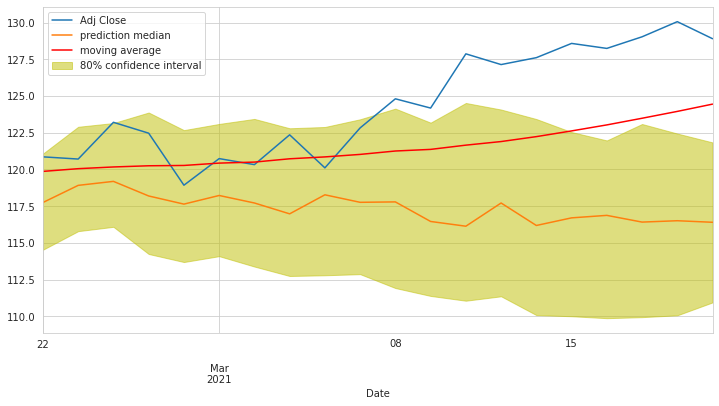

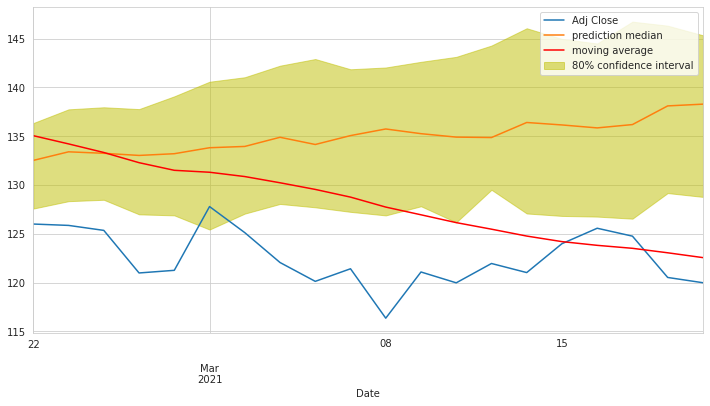

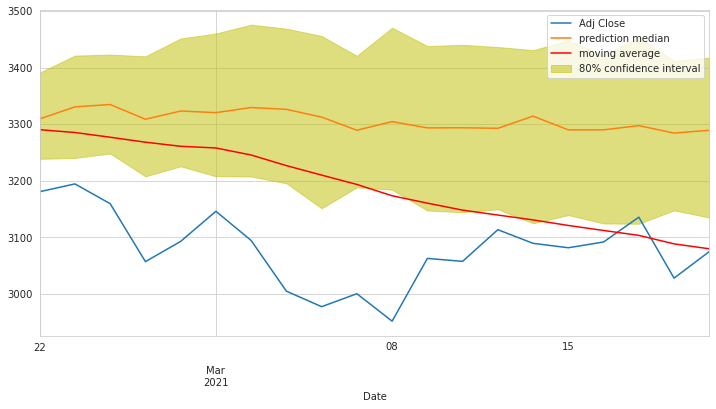

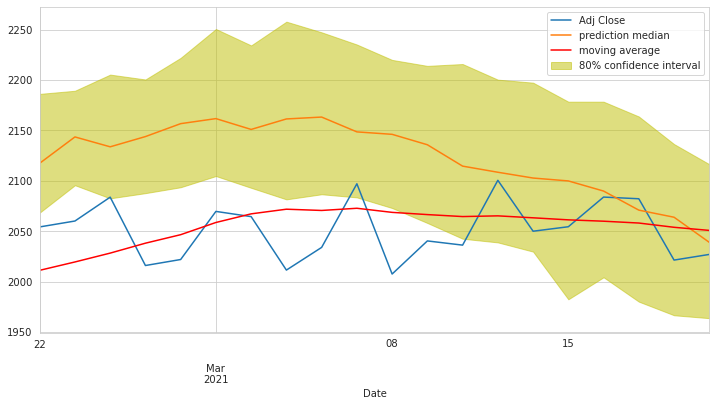

In [353]:
# display predictions
for i in range(len(test_predictions)):
    display_quantiles(valid_predictions_from_ts[i], valid_gt[i], df_valid_ma[i], 'moving average')

## Metrics computation

Now that we have predictions on validation dataset, we can compute our metrics and compare it to benchmakr model performaces.

### IBM Stock prices

Mean Absolute Error

In [ ]:
ibm_dar_mae_loss = mean_absolute_error(test_gt, json_prediction[0]['0.5'])

In [ ]:
print(ibm_dar_mae_loss)

Root Mean Squared Error

In [ ]:
ibm_dar_mse_loss = mean_squared_error(test_gt, json_prediction[0]['0.5'], squared=False)

In [ ]:
print(ibm_dar_mse_loss)

Mean Absolute Percentage Error

In [ ]:
ibm_dar_map_loss = mean_absolute_percentage_error(test_gt, json_prediction[0]['0.5'])

In [ ]:
print(ibm_dar_map_loss)

R<sup>2</sup> score

In [ ]:
ibm_dar_r2_score = r2_score(test_gt, json_prediction[0]['0.5'])

In [ ]:
print(ibm_dar_r2_score)

### Predicting Apple stock price

Ground truth:

In [ ]:
test_gt = df_aapl_test.iloc[-prediction_length[1]:]['Adj Close']

In [ ]:
# get all input and target (test) time series
# input_ts = [df_ibm_train, df_aapl_train, df_amzn_train, df_googl_train]
# target_ts = [df_ibm_test, df_aapl_test, df_amzn_test, df_googl_test]

input_ts = [df_aapl_train]
target_ts = [df_aapl]

# get the prediction from the predictor
json_prediction = json_predictor.predict(input_ts)

In [ ]:
json_prediction[0]

As we can see, index are just progressing of one day each row, wich is not stock price progression scheme in real life (e.g.: weekends are not trading days), so I'm going fix the index before going on with the analysis of results:

In [ ]:
single_prediction = json_prediction[0]

In [ ]:
single_prediction.index = test_gt.index

Save data locally:

In [ ]:
data_dir_json_prediction = os.path.join(data_dir_json, 'prediction') # The folder we will use for storing data
if not os.path.exists(data_dir_json_prediction): # Make sure that the folder exists
    os.makedirs(data_dir_json_prediction)

In [ ]:
start_date = str(single_prediction.index[0].date())
end_date = str(single_prediction.index[-1].date())

Prediction serialization:

In [ ]:
single_prediction.to_json(os.path.join(data_dir_json_prediction, "AAPL_{} - {}.json".format(start_date, end_date)),
                          orient='columns',date_format='iso')

Prediction de-serialization:

In [ ]:
d_single_prediction = pd.read_json(os.path.join(data_dir_json_prediction, "AAPL_{} - {}.json".format(start_date, end_date)),
                                   orient='columns', convert_axes=False)

Simplifying date string

In [ ]:
d_single_prediction.index = d_single_prediction.index

Again, index normalization using target index, before using deserialized data:

In [ ]:
d_single_prediction.index = test_gt.index

#### Metrics computation

Mean Absolute Error

In [ ]:
aapl_dar_mae_loss = mean_absolute_error(test_gt, json_prediction[0]['0.5'])

In [ ]:
print(aapl_dar_mae_loss)

Root Mean Squared Error

In [ ]:
aapl_dar_mse_loss = mean_squared_error(test_gt, json_prediction[0]['0.5'], squared=False)

In [ ]:
print(aapl_dar_mse_loss)

Mean Absolute Percentage Error

In [ ]:
aapl_dar_map_loss = mean_absolute_percentage_error(test_gt, json_prediction[0]['0.5'])

In [ ]:
print(aapl_dar_map_loss)

R<sup>2</sup> score

In [ ]:
aapl_dar_r2_score = r2_score(test_gt, json_prediction[0]['0.5'])

In [ ]:
print(aapl_dar_r2_score)

## Display the Results

The quantile data will give us all we need to see the results of our prediction.
* Quantiles 0.1 and 0.9 represent higher and lower bounds for the predicted values.
* Quantile 0.5 represents the median of all sample predictions.

In [ ]:
# display predictions
display_quantiles(d_single_prediction, prediction_length[1], test_gt)

### Predicting Amazon stock price

Ground truth:

In [ ]:
test_gt = df_amzn_test.iloc[-prediction_length[1]:]['Adj Close']

In [ ]:
# get all input and target (test) time series
# input_ts = [df_ibm_train, df_aapl_train, df_amzn_train, df_googl_train]
# target_ts = [df_ibm_test, df_aapl_test, df_amzn_test, df_googl_test]

input_ts = [df_amzn_train]
target_ts = [df_amzn]

# get the prediction from the predictor
json_prediction = json_predictor.predict(input_ts)

In [ ]:
json_prediction[0]

As we can see, index are just progressing of one day each row, wich is not stock price progression scheme in real life (e.g.: weekends are not trading days), so I'm going fix the index before going on with the analysis of results:

In [ ]:
single_prediction = json_prediction[0]

In [ ]:
single_prediction.index = test_gt.index

Save data locally:

In [ ]:
data_dir_json_prediction = os.path.join(data_dir_json, 'prediction') # The folder we will use for storing data
if not os.path.exists(data_dir_json_prediction): # Make sure that the folder exists
    os.makedirs(data_dir_json_prediction)

In [ ]:
start_date = str(single_prediction.index[0].date())
end_date = str(single_prediction.index[-1].date())

Prediction serialization:

In [ ]:
single_prediction.to_json(os.path.join(data_dir_json_prediction, "AMZN_{} - {}.json".format(start_date, end_date)),
                          orient='columns',date_format='iso')

Prediction de-serialization:

In [ ]:
d_single_prediction = pd.read_json(os.path.join(data_dir_json_prediction, "AMZN_{} - {}.json".format(start_date, end_date)),
                                   orient='columns', convert_axes=False)

Again, index normalization using target index, before using deserialized data:

In [ ]:
d_single_prediction.index = test_gt.index

#### Metrics computation

Mean Absolute Error

In [ ]:
amzn_dar_mae_loss = mean_absolute_error(test_gt, json_prediction[0]['0.5'])

In [ ]:
print(amzn_dar_mae_loss)

Root Mean Squared Error

In [ ]:
amzn_dar_mse_loss = mean_squared_error(test_gt, json_prediction[0]['0.5'], squared=False)

In [ ]:
print(amzn_dar_mse_loss)

Mean Absolute Percentage Error

In [ ]:
amzn_dar_map_loss = mean_absolute_percentage_error(test_gt, json_prediction[0]['0.5'])

In [ ]:
print(amzn_dar_map_loss)

R<sup>2</sup> score

In [ ]:
amzn_dar_r2_score = r2_score(test_gt, json_prediction[0]['0.5'])

In [ ]:
print(amzn_dar_r2_score)

## Display the Results

The quantile data will give us all we need to see the results of our prediction.
* Quantiles 0.1 and 0.9 represent higher and lower bounds for the predicted values.
* Quantile 0.5 represents the median of all sample predictions.

In [ ]:
# display predictions
display_quantiles(d_single_prediction, prediction_length[1], test_gt)

### Predicting Alphabet stock price

Ground truth:

In [ ]:
test_gt = df_googl_test.iloc[-prediction_length[1]:]['Adj Close']

In [ ]:
# get all input and target (test) time series
# input_ts = [df_ibm_train, df_aapl_train, df_amzn_train, df_googl_train]
# target_ts = [df_ibm_test, df_aapl_test, df_amzn_test, df_googl_test]

input_ts = [df_googl_train]
target_ts = [df_googl]

# get the prediction from the predictor
json_prediction = json_predictor.predict(input_ts)

In [ ]:
json_prediction[0]

As we can see, index are just progressing of one day each row, wich is not stock price progression scheme in real life (e.g.: weekends are not trading days), so I'm going fix the index before going on with the analysis of results:

In [ ]:
single_prediction = json_prediction[0]

In [ ]:
single_prediction.index = test_gt.index

Save data locally:

In [ ]:
data_dir_json_prediction = os.path.join(data_dir_json, 'prediction') # The folder we will use for storing data
if not os.path.exists(data_dir_json_prediction): # Make sure that the folder exists
    os.makedirs(data_dir_json_prediction)

In [ ]:
start_date = str(single_prediction.index[0].date())
end_date = str(single_prediction.index[-1].date())

Prediction serialization:

In [ ]:
single_prediction.to_json(os.path.join(data_dir_json_prediction, "GOOGL_{} - {}.json".format(start_date, end_date)),
                          orient='columns',date_format='iso')

Prediction de-serialization:

In [ ]:
d_single_prediction = pd.read_json(os.path.join(data_dir_json_prediction, "GOOGL_{} - {}.json".format(start_date, end_date)),
                                   orient='columns', convert_axes=False)

Again, index normalization using target index, before using deserialized data:

In [ ]:
d_single_prediction.index = test_gt.index

#### Metrics computation

Mean Absolute Error

In [ ]:
googl_dar_mae_loss = mean_absolute_error(test_gt, json_prediction[0]['0.5'])

In [ ]:
print(googl_dar_mae_loss)

Root Mean Squared Error

In [ ]:
googl_ma_mse_loss = mean_squared_error(test_gt, json_prediction[0]['0.5'], squared=False)

In [ ]:
print(googl_ma_mse_loss)

Mean Absolute Percentage Error

In [ ]:
googl_dar_map_loss = mean_absolute_percentage_error(test_gt, json_prediction[0]['0.5'])

In [ ]:
print(googl_dar_map_loss)

R<sup>2</sup> score

In [ ]:
googl_dar_r2_score = r2_score(test_gt, json_prediction[0]['0.5'])

In [ ]:
print(googl_dar_r2_score)

## Display the Results

The quantile data will give us all we need to see the results of our prediction.
* Quantiles 0.1 and 0.9 represent higher and lower bounds for the predicted values.
* Quantile 0.5 represents the median of all sample predictions.

In [ ]:
# display predictions
display_quantiles(d_single_prediction, prediction_length[1], test_gt)

## Delete the Endpoint

Try your code out on different time series. You may want to tweak your DeepAR hyperparameters and see if you can improve the performance of this predictor.

When you're done with evaluating the predictor (any predictor), make sure to delete the endpoint.

In [ ]:
## TODO: delete the endpoint
json_predictor.delete_endpoint()